In [46]:
%pip install pandas torch torchvision openpyxl matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import torch
import torchvision
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
labels = pd.read_excel("dataset_database.xlsx")


In [25]:
path_to_images = "split_dataset/"

transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(path_to_images, transform=transformer)

train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle = True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

classes = ("Crash", "No_Crash")



In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.gap =nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256,128)
        self.fc2 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        
        x = self.gap(x)
        
        x = torch.flatten(x,1)
        
        x = F.relu(self.fc1(x))
        x= self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [27]:
net = Net()

import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [29]:
train_losses = []
train_accuracies = []
test_accuracies = []

threshold = 0.5

for epoch in range(20): 
    
    print("Epoch: ", epoch) 

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        outputs = outputs.squeeze(1)
        
        labels = labels.float()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        probs = torch.sigmoid(outputs)               
        preds = (probs >= threshold).long()         
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss /len(trainloader)
    epoch_acc = 100 *correct/total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    #TEST ACCURACY
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            outputs = outputs.squeeze(1)

            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).long()

            correct_test += (preds == labels.long()).sum().item()
            total_test += labels.size(0)
    
    test_acc = 100* correct_test/ total_test
    test_accuracies.append(test_acc)

print('Finished Training')

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Finished Training


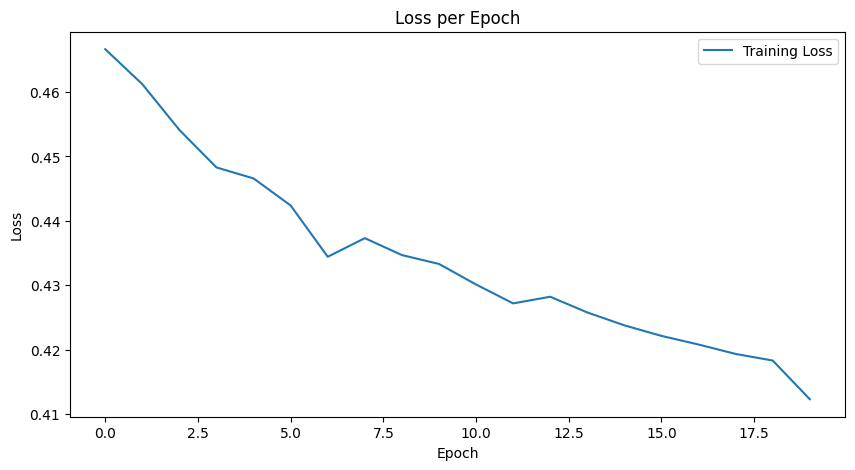

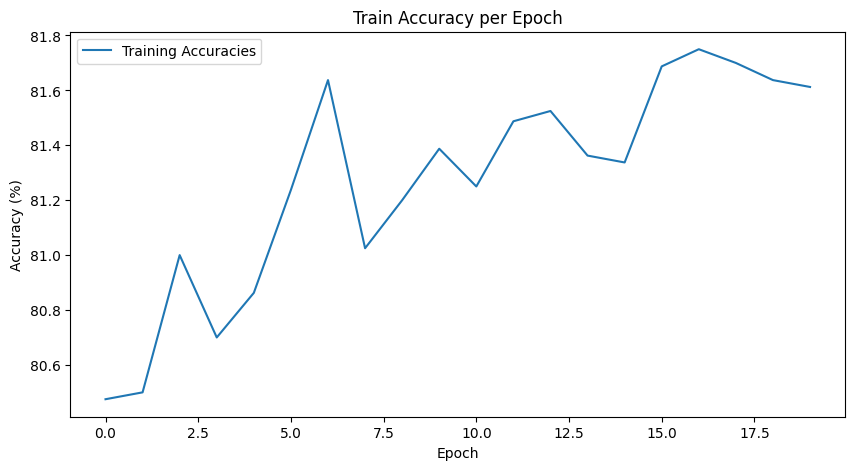

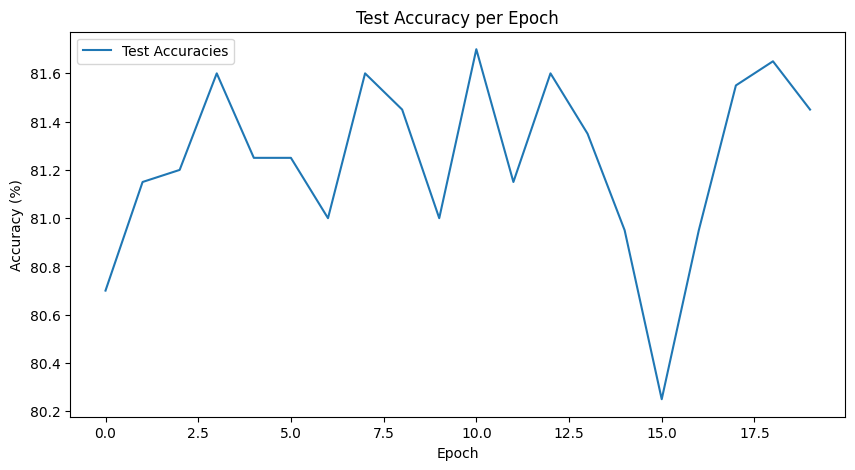

In [32]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label = 'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.savefig("Training Loss")

plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label = 'Training Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train Accuracy per Epoch')
plt.legend()
plt.savefig("Training Accuracy")

plt.figure(figsize=(10,5))
plt.plot(test_accuracies, label = 'Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()
plt.savefig("Test Accuracy")

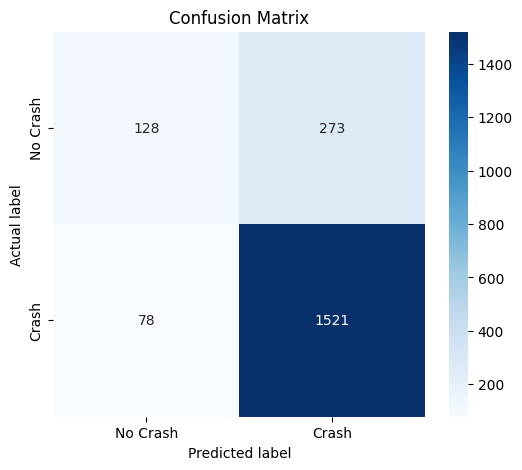

In [48]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve

all_labels = []
all_preds = []
all_probs = []

net.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        outputs = outputs.squeeze(1)
        
        probs = torch.sigmoid(outputs)
        preds = (probs>=0.55).long()
        
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())
        all_probs.extend(probs.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['No Crash', 'Crash'],
            yticklabels=['No Crash', 'Crash'])

plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion Matrix")
plt.show()

In [40]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("Accuracy: ", accuracy)
print("precision: ", precision)
print("Recall: ", recall)
print('F1 score: ', f1)

Accuracy:  0.8245
precision:  0.8478260869565217
Recall:  0.9512195121951219
F1 score:  0.896551724137931


ROC-AUC:  0.795576724230699


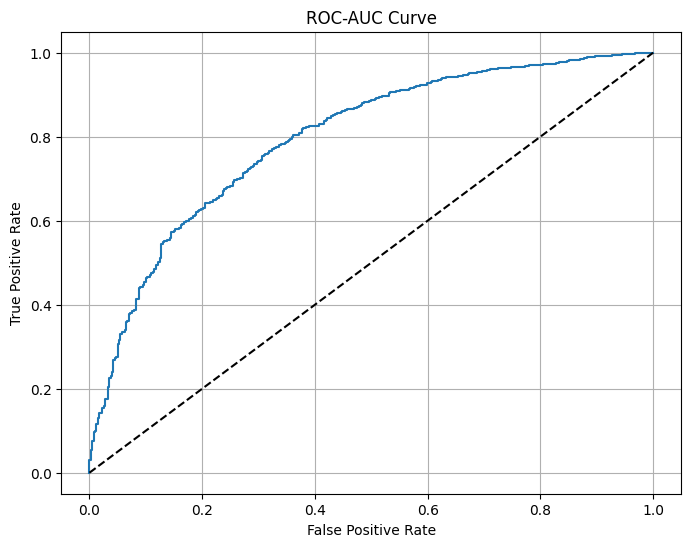

In [44]:
y_true = np.array(all_labels)
y_score = np.array(all_probs)

fpr, tpr, thresholds = roc_curve(y_true, y_score)

auc = roc_auc_score(y_true, y_score)
print("ROC-AUC: ", auc)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.grid(True)
plt.show()